### Importing necessary libraries and datasets

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data= pd.read_csv("train.csv")

In [3]:
test_data= pd.read_csv('test.csv')

In [4]:
train_x = train_data.drop(['topic'], axis = 1)
train_y = train_data.topic
test_x= test_data

In [5]:
train_data = train_data.drop_duplicates('Review Text')

In [6]:
test_data.shape

(2553, 2)

In [7]:
train_data['topic'].unique()

array(['Shipment and delivery', 'Customer Service', 'Allergic', 'Texture',
       'Bad Taste/Flavor', 'Too big to swallow', 'Quality/Contaminated',
       'Smells Bad', 'Too Sweet', 'Not Effective', 'Expiry',
       'Wrong Product received', 'Pricing', 'Color and texture',
       'Packaging', 'False Advertisement', 'Ingredients',
       'Inferior to competitors', 'Customer Issues', "Didn't Like",
       'Hard to Chew'], dtype=object)

In [8]:
concerns_df = train_data.groupby('topic').filter(lambda x: len(x) > 100)
concerns = concerns_df['topic'].value_counts().index.tolist()

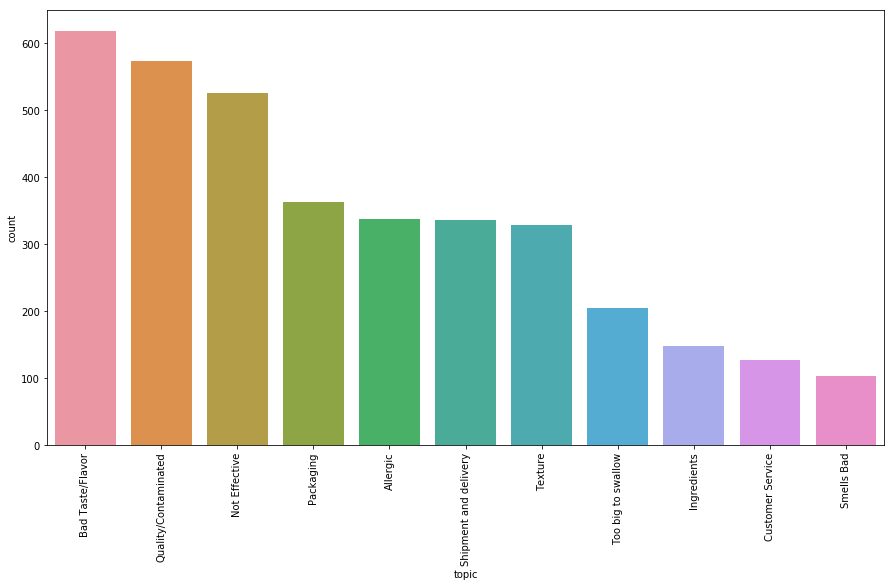

In [9]:
fig, ax = plt.subplots(figsize = (15,8))
sns.countplot(x = concerns_df['topic'], order = concerns, ax = ax)
plt.xticks(rotation = 90)
plt.show()

##### From the reviews in the training data, the top concerns highlighted are:
1)The highest negative reviews for the products are related to their Bad Taste/Flavour

2)Next, Quality of the products is not liked by the customers

3)A lot of people complain about the non-effectiveness of the products

4)Packaging of the products comes out to be among the top most concern of the customers

5)Customers also complain about the texture and allergic reaction due to the use of the products

#### Modeling:Bagging(RandomForestClassifier) &Boosting(XGBClassifier)

In [10]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [11]:
from sklearn.model_selection import train_test_split

X = train_data.drop(['topic'], axis = 1)
y = train_data.topic
x= test_data

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3147, 2) (1049, 2) (3147,) (1049,)


In [12]:
import string
punctuations = string.punctuation
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stop.update(punctuations)

In [13]:
topics =train_data.topic.unique().tolist()
topics.sort()

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(stop_words = stop)
X_train_dtm = vect.fit_transform(X_train['Review Text'])

In [15]:
X_test_dtm = vect.transform(X_test['Review Text'])

In [16]:
models ={}
for z in topics:
    model=RandomForestClassifier(n_estimators=200, random_state=0)
    y=y_train==z
    model.fit(X_train_dtm,y)
    models[z]=model
testing_probs=pd.DataFrame(columns= topics)

In [17]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
model ={}
for z in topics:
    model=XGBClassifier()
    y=y_train==z
    model.fit(X_train_dtm,y)
    models[z]=model
testing_probs=pd.DataFrame(columns= topics)

In [18]:
for topic in topics:
    testing_probs[topic] = models[topic].predict_proba(X_test_dtm)[:,1]
    
predicted_topic = testing_probs.idxmax(axis=1)

comparison = pd.DataFrame({'actual':y_test.values, 'predicted':predicted_topic.values})   

from sklearn.metrics import accuracy_score
print('Accuracy Score:',accuracy_score(comparison.actual, comparison.predicted)*100,"%")
comparison.head()

Accuracy Score: 70.54337464251668 %


,actual,predicted
0,Allergic,Allergic
1,Packaging,Packaging
2,Quality/Contaminated,Bad Taste/Flavor
3,Smells Bad,Color and texture
4,Too Sweet,Too Sweet


In [19]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(stop_words = stop)
train_dtm = vect.fit_transform(train_x['Review Text'])
test_dtm = vect.transform(test_x['Review Text'])

In [20]:
models = {}
for z in topics:
    model = RandomForestClassifier(n_estimators =200, random_state=0)
    
    y = train_y == z
    model.fit(train_dtm, y)
    models[z] = model

testing_probs = pd.DataFrame(columns = topics)


In [21]:
model ={}
for z in topics:
    model=XGBClassifier()
    y=train_y==z
    model.fit(train_dtm,y)
    models[z]=model
testing_probs=pd.DataFrame(columns= topics)

In [22]:
for topic in topics:
    testing_probs[topic] = models[topic].predict_proba(test_dtm)[:,1]
    
predicted_topic = testing_probs.idxmax(axis=1)

#### Saving the results

In [23]:
output = pd.DataFrame({'Review Text': test_data['Review Text'],
                       'Review Title': test_data['Review Title'],
                      'topic':predicted_topic})
output.to_csv('submission.csv', index=False)
output.head()

,Review Text,Review Title,topic
0,I use chia seed in my protein shakes. These ta...,Bad tast,Bad Taste/Flavor
1,I use chia seed in my protein shakes. These ta...,Bad tast,Bad Taste/Flavor
2,Don’t waste your money.,No change. No results.,Not Effective
3,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Ingredients
4,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Ingredients


In [24]:
concerns_df = output.groupby('topic').filter(lambda x: len(x) > 100)
concerns = concerns_df['topic'].value_counts().index.tolist()

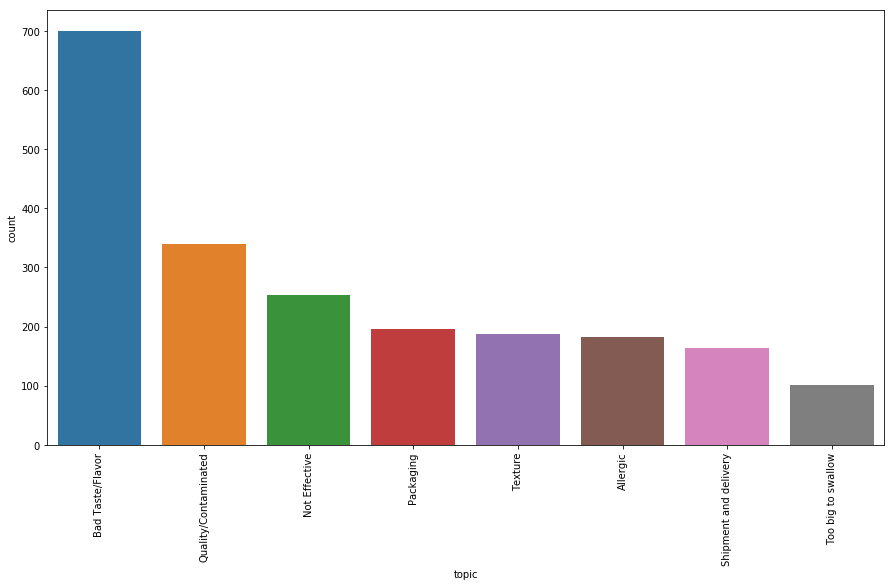

In [25]:
fig, ax = plt.subplots(figsize = (15,8))
sns.countplot(x = concerns_df['topic'], order = concerns, ax = ax)
plt.xticks(rotation = 90)
plt.show()

### From the analysis of reviews, it can be inferred that the top most 3 concern of customers relates to the Bad Taste/Flavour , Quality, and non-effectiveness of the product